In [16]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

In [27]:
# 策略继承CtaTemplate
class MultiKlineStrategy(CtaTemplate):
    className = 'MultiKlineStrategy'
    author = 'howers'
    # 策略参数
    trailingPct = 0.16  
    KlinePct = 0.64
    #KmaxPct = 0.98
    lot = 1
    # 策略变量
    candle60= {};candle30= {}
    candle15= {}
    transactionPrice = {} # 记录成交价格
    # 参数列表，保存了参数的名称
    paramList = [
                 'trailingPct','KlinePct'
                ]    
    # 变量列表，保存了变量的名称
    varList = [
               'candle60','candle30',
               'candle15',
               'transactionPrice'
              ]  
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.candle60 = {s:0 for s in self.symbolList}
        self.candle30 = {s:0 for s in self.symbolList}
        self.candle15 = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s: 0 for s in self.symbolList}
        self.intraTradeLowDict = {s: 999999 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        # 变量初始化
        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999
        # 持有多头仓位
        elif self.posDict[symbol + "_LONG"] > 0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            longStop = self.intraTradeHighDict[symbol] * (1-self.trailingPct)
            if bar.low <= longStop:
#                 print('longStop')
                self.cancelAll()
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            shortStop = self.intraTradeLowDict[symbol] * (1 + self.trailingPct)
            if bar.high >= shortStop:
#                 print('shortStop')
                self.cancelAll()
                self.cover(symbol, bar.close * 1.01, self.posDict[symbol + "_SHORT"])
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        if not am60.inited:
            return
        # 计算均线并判断趋势
        lowlead = ((min(am60.close[-1],am60.open[-1])-am60.low[-1])/(am60.high[-1]-am60.low[-1]))>self.KlinePct 
        toplead = ((am60.high[-1]-max(am60.close[-1],am60.open[-1]))/(am60.high[-1]-am60.low[-1]))>self.KlinePct  
        
        #定义事件信号
        if lowlead:
            self.candle60[symbol] = -100 
        elif toplead:
            self.candle60[symbol] = 100 
     #----------------------------------------------------------------------
    def on30MinBar(self, bar):
        """收到30MinBar推送"""
        symbol = bar.vtSymbol
        am30 = self.getArrayManager(symbol, "30m")
        if not am30.inited:
            return
        # 计算均线并判断趋势
        
        darkcloudcover = ta.CDLDARKCLOUDCOVER(am30.open, am30.high, am30.low, am30.close, penetration=0)
        gapsidesidewhite = ta.CDLGAPSIDESIDEWHITE(am30.open, am30.high, am30.low, am30.close) 
        harami=ta.CDLHARAMI(am30.open, am30.high, am30.low, am30.close)   
        haramicross=ta.CDLHARAMICROSS(am30.open, am30.high, am30.low, am30.close) 
        kicking = ta.CDLKICKING(am30.open, am30.high, am30.low, am30.close)
        kickgbylength = ta.CDLKICKINGBYLENGTH(am30.open, am30.high, am30.low, am30.close)
        piercing = ta.CDLPIERCING(am30.open, am30.high, am30.low, am30.close)   
        separatinglines = ta.CDLSEPARATINGLINES(am30.open, am30.high, am30.low, am30.close)
       
        #定义事件信号
        self.candle30[symbol]=-darkcloudcover+gapsidesidewhite-harami-haramicross+kicking+kickgbylength-piercing-separatinglines
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        am15 = self.getArrayManager(symbol, "15m")
        if not am15.inited:
            return
        
        threeoutside= ta.CDL3OUTSIDE(am15.open, am15.high, am15.low, am15.close)  
        sanwhitesolders = ta.CDL3WHITESOLDIERS(am15.open, am15.high, am15.low, am15.close)
        eveningdojistar=ta.CDLEVENINGDOJISTAR(am15.open, am15.high, am15.low, am15.close, penetration=0)
        stalledpattern = ta.CDLSTALLEDPATTERN(am15.open, am15.high, am15.low, am15.close)  
        sticksandwich = ta.CDLSTICKSANDWICH(am15.open, am15.high, am15.low, am15.close)
        tasukigap = ta. CDLTASUKIGAP(am15.open, am15.high, am15.low, am15.close) 
        tristar= ta.CDLTRISTAR(am15.open, am15.high, am15.low, am15.close)
        unique3rever=ta.CDLUNIQUE3RIVER(am15.open, am15.high, am15.low, am15.close) 
        xsidegap3methods = ta.CDLXSIDEGAP3METHODS(am15.open, am15.high, am15.low, am15.close) 
        
        self.candle15[symbol]=-threeoutside+sanwhitesolders-eveningdojistar-stalledpattern+sticksandwich-tasukigap-unique3rever-xsidegap3methods-tristar
        
        Signal=self.candle15[symbol]+self.candle30[symbol]+self.candle60[symbol]
        
        if (Signal[-1]>=200) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        if (Signal[-1]<=-200) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做交易信息记录的策略，可以忽略onTrade
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [28]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180115 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181210 12:00') # 设置回测用的数据终止日期
    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金
    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiKlineStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 15:03:02.623906	开始回测
2018-12-23 15:03:02.623906	策略初始化
2018-12-23 15:03:03.118234	数据载入完成, 时间段:[20180107 04:00,20180115 12:00);数据量:12000
2018-12-23 15:03:03.119234	初始化预加载数据成功, 数据长度:12000
2018-12-23 15:03:03.119234	策略初始化完成
2018-12-23 15:03:03.119234	策略启动完成
2018-12-23 15:03:03.119234	回测时间范围:[20180115 12:00,20181210 12:00)
2018-12-23 15:03:03.119234	当前回放的时间段:[20180115 12:00,20181210 12:00)
2018-12-23 15:03:24.176274	数据载入完成, 时间段:[20180115 12:00,20181210 12:00);数据量:469909
2018-12-23 15:03:24.362397	数据载入完成, 时间段:[20180114 20:51,20180117 12:01);数据量:3790
2018-12-23 15:03:25.540183	数据载入完成, 时间段:[20171208 15:00,20180114 20:50);数据量:19845
2018-12-23 15:03:25.544185	WARNING: 该时间段:[20180117 12:01,20180117 13:00) 数据量为0!
20180115 18:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180117 21:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180119 04:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:bin

20180430 05:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180502 16:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180503 04:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180504 11:20:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180504 16:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180507 20:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180508 09:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180509 20:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180511 11:35:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180512 01:50:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180512 18:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180513 08:05:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180514 13:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180515 15:20:00 {'BTCUSDT:binance_LO

20180821 00:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180822 09:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180822 12:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180823 11:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180826 01:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180826 10:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180828 07:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180828 08:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180828 12:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180828 23:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180829 06:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180830 03:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180901 09:00:0004.477446	Progress: 69%     {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180903 03

20181130 05:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181130 06:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181201 04:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181201 14:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181201 17:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181203 12:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181203 21:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181204 17:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181204 23:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181205 16:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181206 08:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181206 16:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181206 20:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181207 00:00:00 {'BTCUSDT:binance_LO

KeyError: 'dt'

2018-12-23 15:05:47.299812	计算按日统计结果
2018-12-23 15:05:47.340839	------------------------------
2018-12-23 15:05:47.340839	首个交易日：	2018-01-15 00:00:00
2018-12-23 15:05:47.340839	最后交易日：	2018-12-10 00:00:00
2018-12-23 15:05:47.340839	总交易日：	330
2018-12-23 15:05:47.340839	盈利交易日	182
2018-12-23 15:05:47.340839	亏损交易日：	148
2018-12-23 15:05:47.340839	起始资金：	1000000
2018-12-23 15:05:47.340839	结束资金：	1,019,915.52
2018-12-23 15:05:47.341840	总收益率：	1.99%
2018-12-23 15:05:47.341840	年化收益：	1.45%
2018-12-23 15:05:47.341840	总盈亏：	19,915.52
2018-12-23 15:05:47.341840	最大回撤: 	-5,167.8
2018-12-23 15:05:47.341840	百分比最大回撤: -0.51%
2018-12-23 15:05:47.341840	总手续费：	2,506.57
2018-12-23 15:05:47.341840	总滑点：	1.36
2018-12-23 15:05:47.341840	总成交金额：	5,013,145.05
2018-12-23 15:05:47.341840	总成交笔数：	679
2018-12-23 15:05:47.341840	日均盈亏：	60.35
2018-12-23 15:05:47.341840	日均手续费：	7.6
2018-12-23 15:05:47.341840	日均滑点：	0.0
2018-12-23 15:05:47.341840	日均成交金额：	15,191.35
2018-12-23 15:05:47.341840	日均成交笔数：	2.06
2018-12-23 15:05:47.341840	日均收

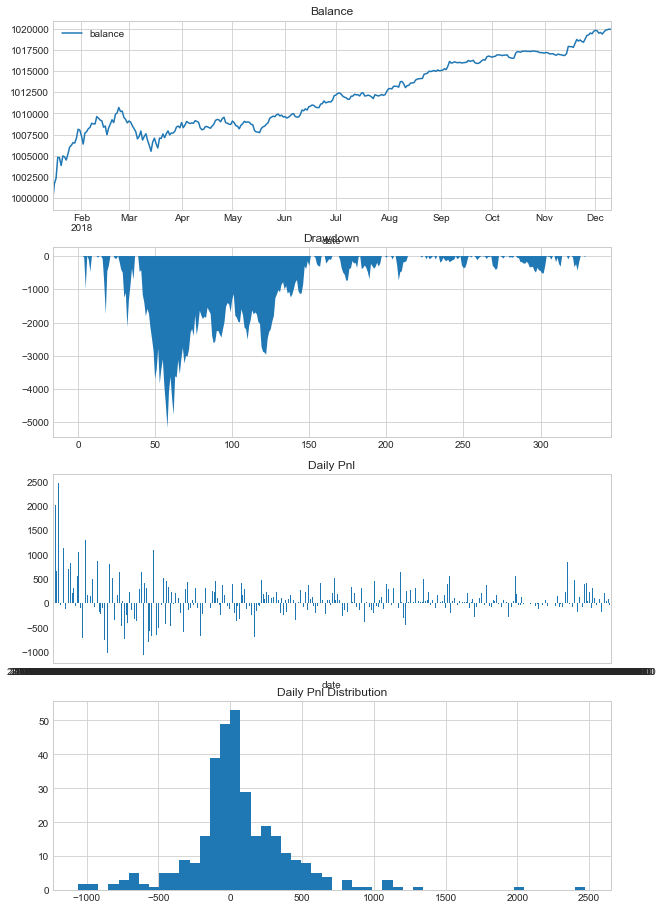

In [29]:
engine.showDailyResult()

2018-12-23 14:17:35.658595	计算回测结果
2018-12-23 14:17:35.696633	------------------------------
2018-12-23 14:17:35.696633	第一笔交易：	2018-01-17 06:39:00
2018-12-23 14:17:35.696633	最后一笔交易：	2018-12-01 11:58:00
2018-12-23 14:17:35.697621	总交易次数：	325
2018-12-23 14:17:35.697621	总盈亏：	19,671.05
2018-12-23 14:17:35.697621	最大回撤: 	-5,219.72
2018-12-23 14:17:35.697621	平均每笔盈利：	60.53
2018-12-23 14:17:35.697621	平均每笔滑点：	0.0
2018-12-23 14:17:35.697621	平均每笔佣金：	7.54
2018-12-23 14:17:35.697621	胜率		48.31%
2018-12-23 14:17:35.697621	盈利交易平均值	287.72
2018-12-23 14:17:35.697621	亏损交易平均值	-151.79
2018-12-23 14:17:35.697621	盈亏比：	1.9


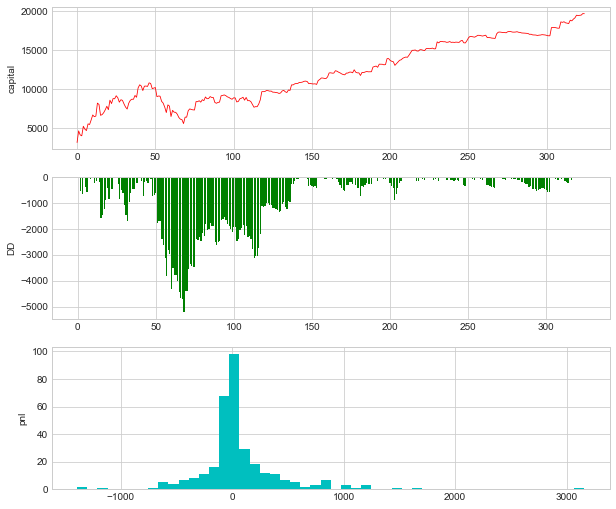

In [20]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [30]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)
print(pd.Series(result))

2018-12-23 15:29:04.730884	计算按日统计结果
annualizedReturn                 1.4484
dailyCommission                 7.59567
dailyNetPnl                     60.3501
dailyReturn                  0.00603501
dailySlippage                0.00411515
dailyTradeCount                 2.05758
dailyTurnover                   15191.3
endBalance                  1.01992e+06
endDate             2018-12-10 00:00:00
lossDays                            148
maxDdPercent                  -0.511308
maxDrawdown                     -5167.8
profitDays                          182
returnStd                     0.0375152
sharpeRatio                     2.49216
startDate           2018-01-15 00:00:00
totalCommission                 2506.57
totalDays                           330
totalNetPnl                     19915.5
totalReturn                     1.99155
totalSlippage                     1.358
totalTradeCount                     679
totalTurnover               5.01315e+06
dtype: object


In [24]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
#setting.addParameter('trailingPct', 0.06, 0.2, 0.02)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('KmaxPct', 0.68, 0.8, 0.03)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5
setting.addParameter('symbolList', ['BTCUSDT:binance']) 
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiKlineStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-23 14:33:50.752786	------------------------------
2018-12-23 14:33:50.752786	setting: {'KmaxPct': 0.68, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 14:33:50.767795	开始回测
2018-12-23 14:33:50.767795	策略初始化
2018-12-23 14:33:51.244120	数据载入完成, 时间段:[20180107 04:00,20180115 12:00);数据量:12000
2018-12-23 14:33:51.244120	初始化预加载数据成功, 数据长度:12000
2018-12-23 14:33:51.245120	策略初始化完成
2018-12-23 14:33:51.245120	策略启动完成
2018-12-23 14:33:51.245120	回测时间范围:[20180115 12:00,20181201 12:00)
2018-12-23 14:33:51.245120	当前回放的时间段:[20180115 12:00,20181201 12:00)
2018-12-23 14:34:09.626413	数据载入完成, 时间段:[20180115 12:00,20181201 12:00);数据量:456949
2018-12-23 14:34:09.801525	数据载入完成, 时间段:[20180114 20:51,20180117 12:01);数据量:3790
2018-12-23 14:34:10.882257	数据载入完成, 时间段:[20171208 15:00,20180114 20:50);数据量:19845
2018-12-23 14:34:10.885247	WARNING: 该时间段:[20180117 12:01,20180117 13:00) 数据量为0!
20180115 18:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:bina

20180428 20:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180429 03:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180430 05:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180502 16:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180503 04:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180504 11:20:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180504 16:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180507 20:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180508 09:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180509 20:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180511 11:35:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180512 01:50:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180512 18:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180513 08:05:00 {'BTCUSDT:binance_LO

20180819 09:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180821 00:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180822 09:00:0046.075222	Progress: 68%     {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180822 12:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180823 11:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180826 01:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180826 10:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180828 07:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180828 08:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180828 12:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180828 23:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180829 06:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180830 03:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180901 09

20181130 05:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181130 06:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181201 04:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 14:35:00.630924	回放结束ress: 100%    
2018-12-23 14:35:00.630924	计算按日统计结果
2018-12-23 14:35:00.853072	------------------------------
2018-12-23 14:35:00.853072	setting: {'KmaxPct': 0.7100000000000001, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 14:35:00.865079	开始回测
2018-12-23 14:35:00.865079	策略初始化
2018-12-23 14:35:01.331391	数据载入完成, 时间段:[20180107 04:00,20180115 12:00);数据量:12000
2018-12-23 14:35:01.332391	初始化预加载数据成功, 数据长度:12000
2018-12-23 14:35:01.332391	策略初始化完成
2018-12-23 14:35:01.332391	策略启动完成
2018-12-23 14:35:01.332391	回测时间范围:[20180115 12:00,20181201 12:00)
2018-12-23 14:35:01.332391	当前回放的时间段:[20180115 12:00,20181201 12:00)
2018-12-23 14:35:20.167140	数据载入完成, 时间段:[20180115 12:00,20181201 

20180424 00:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180424 11:50:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180427 19:05:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180428 20:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180429 03:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180430 05:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180502 16:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180503 04:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180504 11:20:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180504 16:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180507 20:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180508 09:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180509 20:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180511 11:35:00 {'BTCUSDT:binance_LO

20181125 08:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181125 17:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181126 13:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181128 11:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181129 01:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181129 07:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181130 05:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181130 06:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181201 04:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 14:36:11.175522	回放结束ress: 100%    
2018-12-23 14:36:11.175522	计算按日统计结果
2018-12-23 14:36:11.403674	------------------------------
2018-12-23 14:36:11.404675	setting: {'KmaxPct': 0.7400000000000001, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 14:36:11

20180413 11:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180414 11:05:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180416 16:50:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180417 18:20:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180421 11:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180421 12:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180424 00:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180424 11:50:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180427 19:05:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180428 20:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180429 03:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180430 05:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180502 16:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180503 04:05:00 {'BTCUSDT:binance_LO

20180810 21:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180811 21:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180812 15:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180815 03:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180815 20:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180817 07:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180817 19:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180819 09:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180821 00:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180822 09:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180822 12:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180823 11:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180826 01:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180826 10:15:00 {'BTCUSDT:binance_LO

20181124 18:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181125 00:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181125 08:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181125 17:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181126 13:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181128 11:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181129 01:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181129 07:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181130 05:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181130 06:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181201 04:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 14:37:24.036183	回放结束ress: 100%    
2018-12-23 14:37:24.036183	计算按日统计结果
2018-12-23 14:37:24.275342	------------------------------
2018-12-23 14:37:24.275342	setting: {'KmaxPct'

20180407 18:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180412 08:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180412 12:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180413 11:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180414 11:05:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180416 16:50:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180417 18:20:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180421 11:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180421 12:35:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180424 00:05:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180424 11:50:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180427 19:05:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180428 20:20:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180429 03:35:00 {'BTCUSDT:binance_LO

20180807 16:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180807 22:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180809 09:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180809 16:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180810 07:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180810 13:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180810 21:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180811 21:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180812 15:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180815 03:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180815 20:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180817 07:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20180817 19:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20180819 09:45:00 {'BTCUSDT:binance_LO

20181118 12:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181119 02:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181120 23:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181121 13:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181122 21:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181123 22:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181124 18:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181125 00:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181125 08:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181125 17:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181126 13:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181128 11:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
20181129 01:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
20181129 07:30:00 {'BTCUSDT:binance_LO